In [320]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [321]:
import requests
import pandas as pd
import numpy as np

contracts_url = 'https://www.politicalalertengine.com/api/contracts/all'

r = requests.get(contracts_url)

contracts = r.json()

prices_url = 'https://www.politicalalertengine.com/api/analytics/dataByIds/%d'

prices = requests.get(prices_url % 4390).json()

In [322]:
dem_df = get_prices(4390)


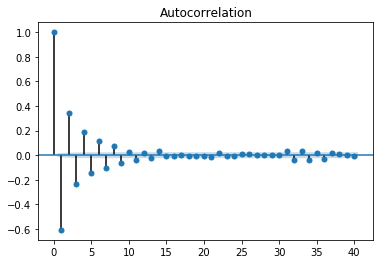

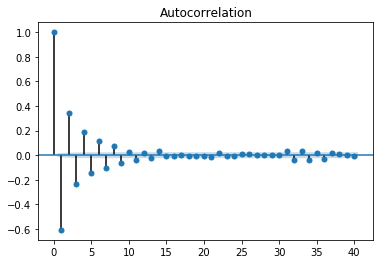

In [323]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(dem_df['lastTradePrice'].diff().dropna(), lags=40)

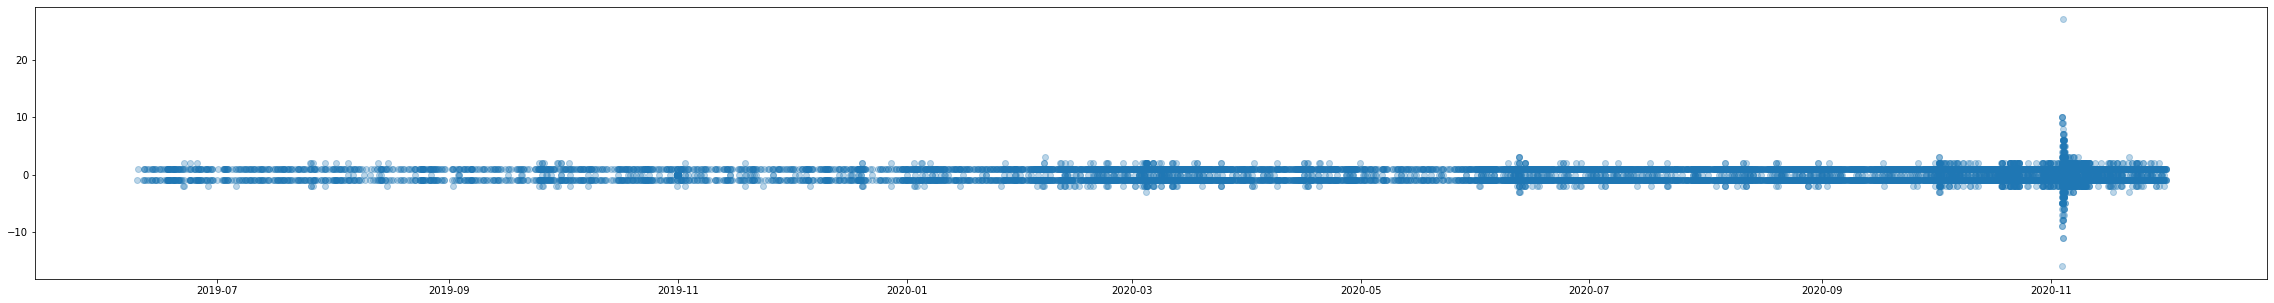

In [326]:
fig = plt.figure(figsize=(40,5))

plt.plot(dem_df.index, dem_df['lastTradePrice'].diff(),'o',alpha=0.3)

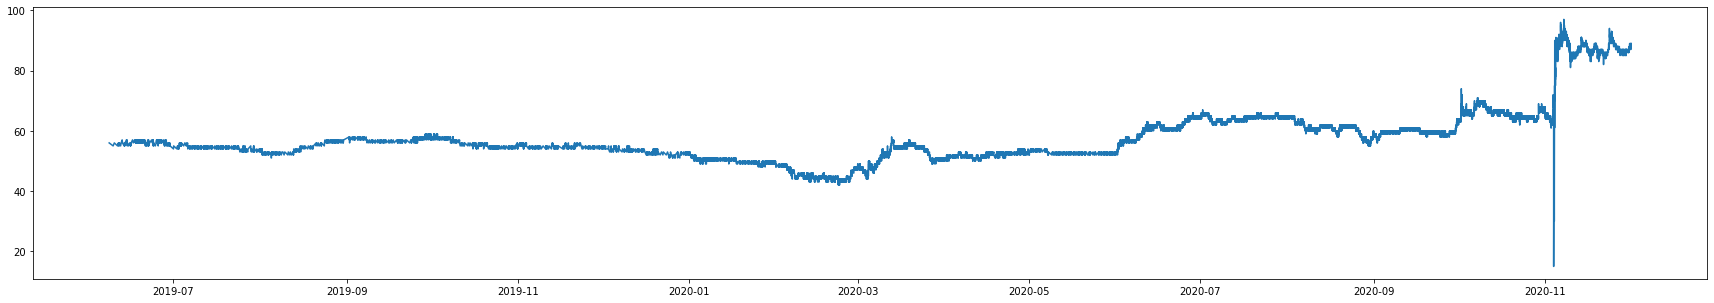

In [367]:
fig = plt.figure(figsize=(30,5))
plt.plot(dem_df['lastTradePrice'])

In [373]:
fig = plt.figure(figsize=(30,5))
# plt.plot(dem_df['lastTradePrice'])
dem_df['price_chng'] = dem_df['lastTradePrice'].diff()

<Figure size 2160x360 with 0 Axes>

In [374]:
dem_df['last_nonzero_chng'] = dem_df['price_chng']

In [375]:
dem_df.loc[dem_df['last_nonzero_chng'] == 0, 'last_nonzero_chng'] = np.nan
dem_df['last_nonzero_chng'] = dem_df['last_nonzero_chng'].ffill()

In [376]:
# guess bid and ask base
def set_bid(r):
    if r['last_nonzero_chng'] < 0:
        return r['lastTradePrice']
#     elif r['price_chng'] > 0:
    else:
        return r['lastTradePrice'] - r['last_nonzero_chng']
    
def set_ask(r):
    if r['last_nonzero_chng'] > 0:
        return r['lastTradePrice']
#     elif r['price_chng'] > 0:
    else:
        return r['lastTradePrice'] - r['last_nonzero_chng']
    
    
dem_df['bid'] = dem_df.apply(lambda r: set_bid(r), axis=1)
dem_df['ask'] = dem_df.apply(lambda r: set_ask(r), axis=1)

In [337]:
# want to predict next price change
# data is list of price changes
# exit rule : when price changes, close position

from sklearn import linear_model
X = dem_df['lastTradePrice'].diff().dropna().iloc[:-1]
X = X.to_numpy().reshape((len(X),1))
y = dem_df['lastTradePrice'].diff().dropna().iloc[1:]
reg = linear_model.LinearRegression().fit(X,y)
# what's the r^2?


In [340]:
reg.score(X,y)

0.3692752390165108

In [358]:
def get_xy_df(s):
#     print(s)
    X = s.diff().dropna().iloc[:-1]
    X = X.to_numpy().reshape((len(X),1))
    y = s.diff().dropna().iloc[1:]
    return X,y

In [359]:
# assuming we get filled on the side we want no matter what

lookback=100
pnls = []
for ind in range(lookback,len(dem_df) - 1):
    if ind % 100 == 0:
        print(ind)
    history = dem_df.iloc[ind - lookback:ind]
    X,y = get_xy_df(history['lastTradePrice'])
    reg = linear_model.LinearRegression().fit(X,y)
    pred = reg.predict([[dem_df.iloc[ind]['lastTradePrice'] - dem_df.iloc[ind - 1]['lastTradePrice']]])
    if pred > 0:
        pnls.append(dem_df.iloc[ind + 1]['lastTradePrice'] - dem_df.iloc[ind]['lastTradePrice'])
    if pred < 0:
        pnls.append(dem_df.iloc[ind]['lastTradePrice'] - dem_df.iloc[ind + 1]['lastTradePrice'])
    ind += 1

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900


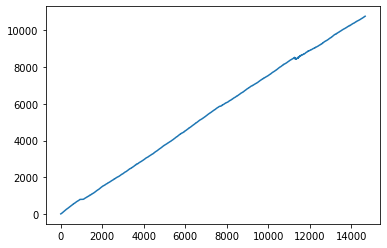

In [361]:
plt.plot(np.cumsum(pnls))

In [360]:
# simple market making strategy: always quote on bid and ask
# much more realistic - applying probabilty of getting filled as market maker

lookback=100
# pnls = []
trade_size = 100
avg_px = 0
num_contracts = 0
for ind in range(1,len(dem_df)):
# for ind in range(lookback,len(dem_df) - 1):
    if ind % 100 == 0:
        print(ind)
    history = dem_df.iloc[ind - lookback:ind]
    last_bid = dem_df.iloc[ind - 1]['bid']
    last_ask = dem_df.iloc[ind - 1]['ask']
    
    trade_px = dem_df.iloc[ind]['lastTradePrice']
    
    if trade_px <= bid:
        num_contracts += trade_size
            
#     X,y = get_xy_df(history['lastTradePrice'])
#     reg = linear_model.LinearRegression().fit(X,y)
#     pred = reg.predict([[dem_df.iloc[ind]['lastTradePrice'] - dem_df.iloc[ind - 1]['lastTradePrice']]])
#     if pred > 0:
#         pnls.append(dem_df.iloc[ind + 1]['lastTradePrice'] - dem_df.iloc[ind]['lastTradePrice'])
#     if pred < 0:
#         pnls.append(dem_df.iloc[ind]['lastTradePrice'] - dem_df.iloc[ind + 1]['lastTradePrice'])
#     ind += 1

[1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 2.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 

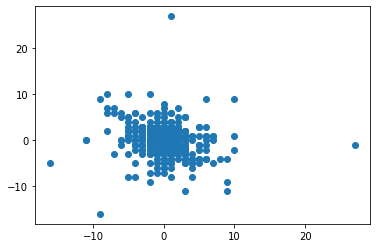

In [348]:
plt.scatter(dem_df['lastTradePrice'].diff(),dem_df['lastTradePrice'].diff().shift(-1))

In [346]:
dem_df['lastTradePrice'].diff().value_counts()

 1.0     6465
-1.0     6406
 0.0     1105
-2.0      398
 2.0      375
 3.0       43
-3.0       34
-4.0       17
-5.0       14
 5.0       10
 4.0       10
 6.0       10
-6.0        5
-8.0        4
 7.0        4
 10.0       3
-7.0        3
 9.0        3
-11.0       2
-9.0        2
-16.0       1
 8.0        1
 27.0       1
Name: lastTradePrice, dtype: int64

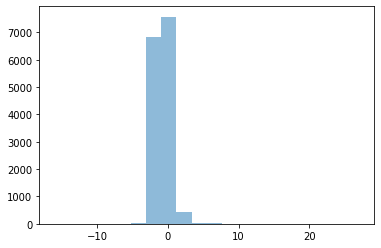

In [345]:
_ = plt.hist(dem_df['lastTradePrice'].diff(),bins=20,alpha=0.5)

In [327]:
def get_prices(c_id):
    df = requests.get(prices_url % c_id).json()
    df = pd.DataFrame(df)
    df['date'] = pd.to_datetime(df['date'])
    df['lastTradePrice'] = df['lastTradePrice'].astype(np.float64)
    df['dateCol'] = df['date']
    df= df.set_index('date')
    return df

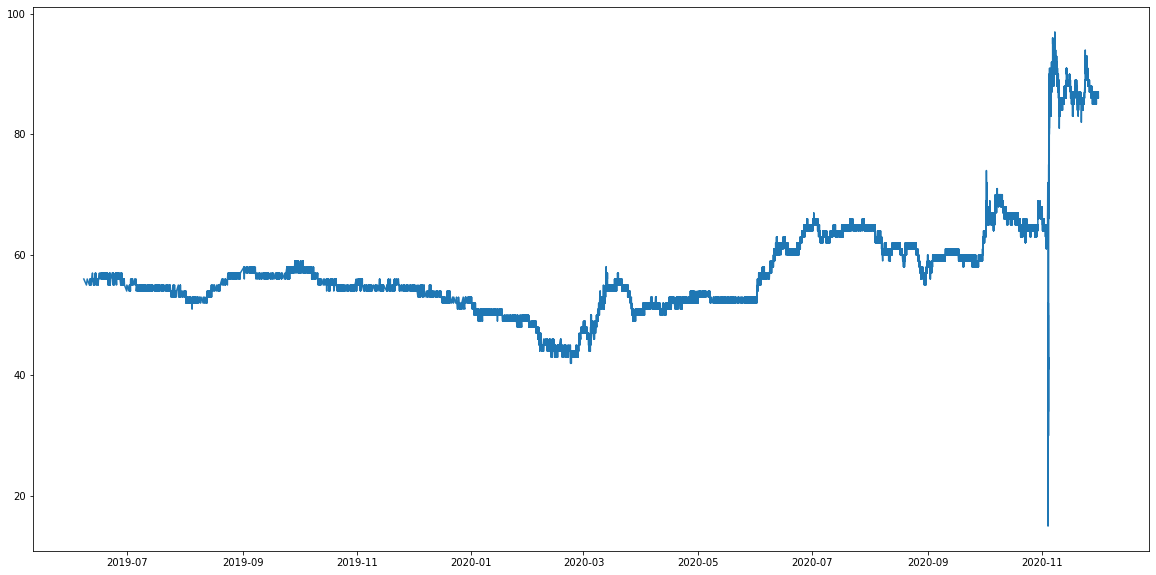

In [270]:
df = pd.DataFrame(prices)

df['date'] = pd.to_datetime(df['date'])
df['lastTradePrice'] = df['lastTradePrice'].astype(np.float64)

c_df = pd.DataFrame(contracts)

c_df[c_df['predictItId'] == 4390]

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
plt.plot(df['lastTradePrice'])

<Figure size 432x288 with 0 Axes>

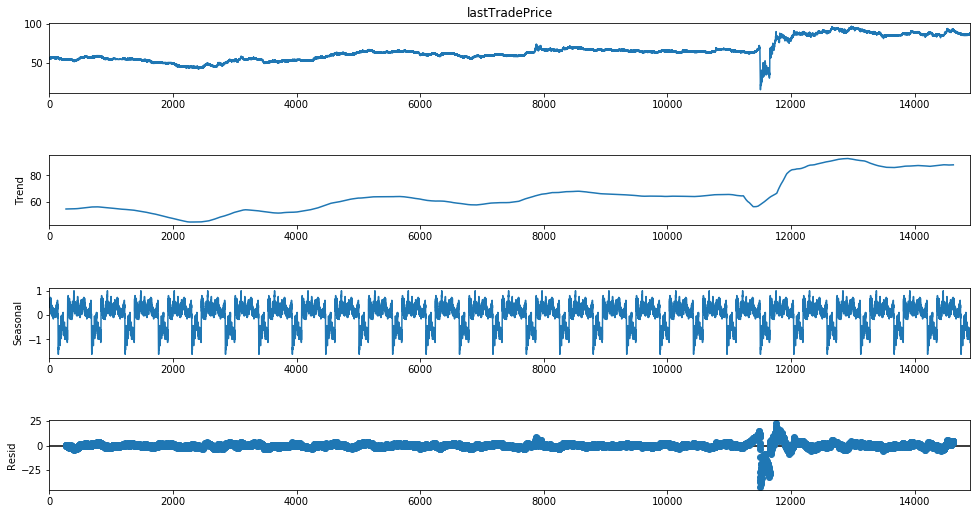

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['lastTradePrice'], period=541)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [5]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['lastTradePrice'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """Entry point for launching an IPython kernel.


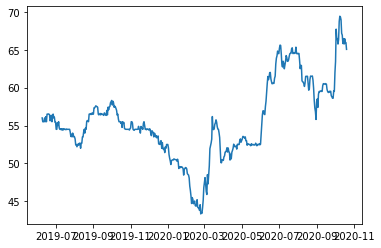

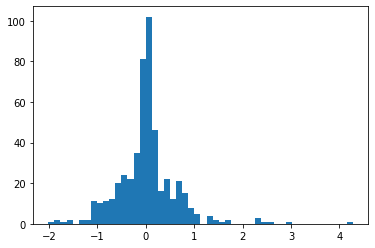

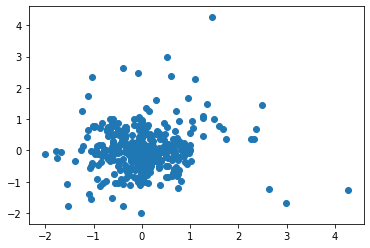

0.07467864919678248

In [268]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [7]:
adf_check(df['lastTradePrice'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.7005449130753703
p-value : 0.43083174314935935
#Lags Used : 39
Number of Observations Used : 14859
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [8]:
df['dateCol'] = df['date']
df= df.set_index('date')


df = df[df.index <= '2020-11-01']

In [ ]:
plot

In [ ]:
# 3698 - id for market on various candidates for president
# 1. after jump in longshot price, should mean-revert (e.g andrew yang rallies)

In [281]:
c_prez = c_df[c_df['parentId'] == 3698]

In [291]:
prez_dfs = [get_prices(r['predictItId']) for idx,r in c_prez.iterrows()]

In [292]:
len(prez_dfs)

26

In [364]:
dem_df[(dem_df.index >= '2020-10-01') & (dem_df.index <= '2020-11-01')]

,id,predictItId,lastTradePrice,lastClose,dateCol
date,,,,,
2020-10-01 00:43:28.950000+00:00,27130866,4390,63.0,None,2020-10-01 00:43:28.950000+00:00
2020-10-01 00:43:36.144000+00:00,27130869,4390,63.0,None,2020-10-01 00:43:36.144000+00:00
2020-10-01 01:22:57.688000+00:00,27131253,4390,64.0,None,2020-10-01 01:22:57.688000+00:00
2020-10-01 01:29:49.262000+00:00,27131301,4390,62.0,None,2020-10-01 01:29:49.262000+00:00
2020-10-01 01:39:01.893000+00:00,27131362,4390,63.0,None,2020-10-01 01:39:01.893000+00:00
...,...,...,...,...,...
2020-10-31 22:41:40.425000+00:00,27527459,4390,66.0,None,2020-10-31 22:41:40.425000+00:00
2020-10-31 22:58:00.298000+00:00,27527743,4390,67.0,None,2020-10-31 22:58:00.298000+00:00
2020-10-31 23:29:14.314000+00:00,27528513,4390,68.0,None,2020-10-31 23:29:14.314000+00:00


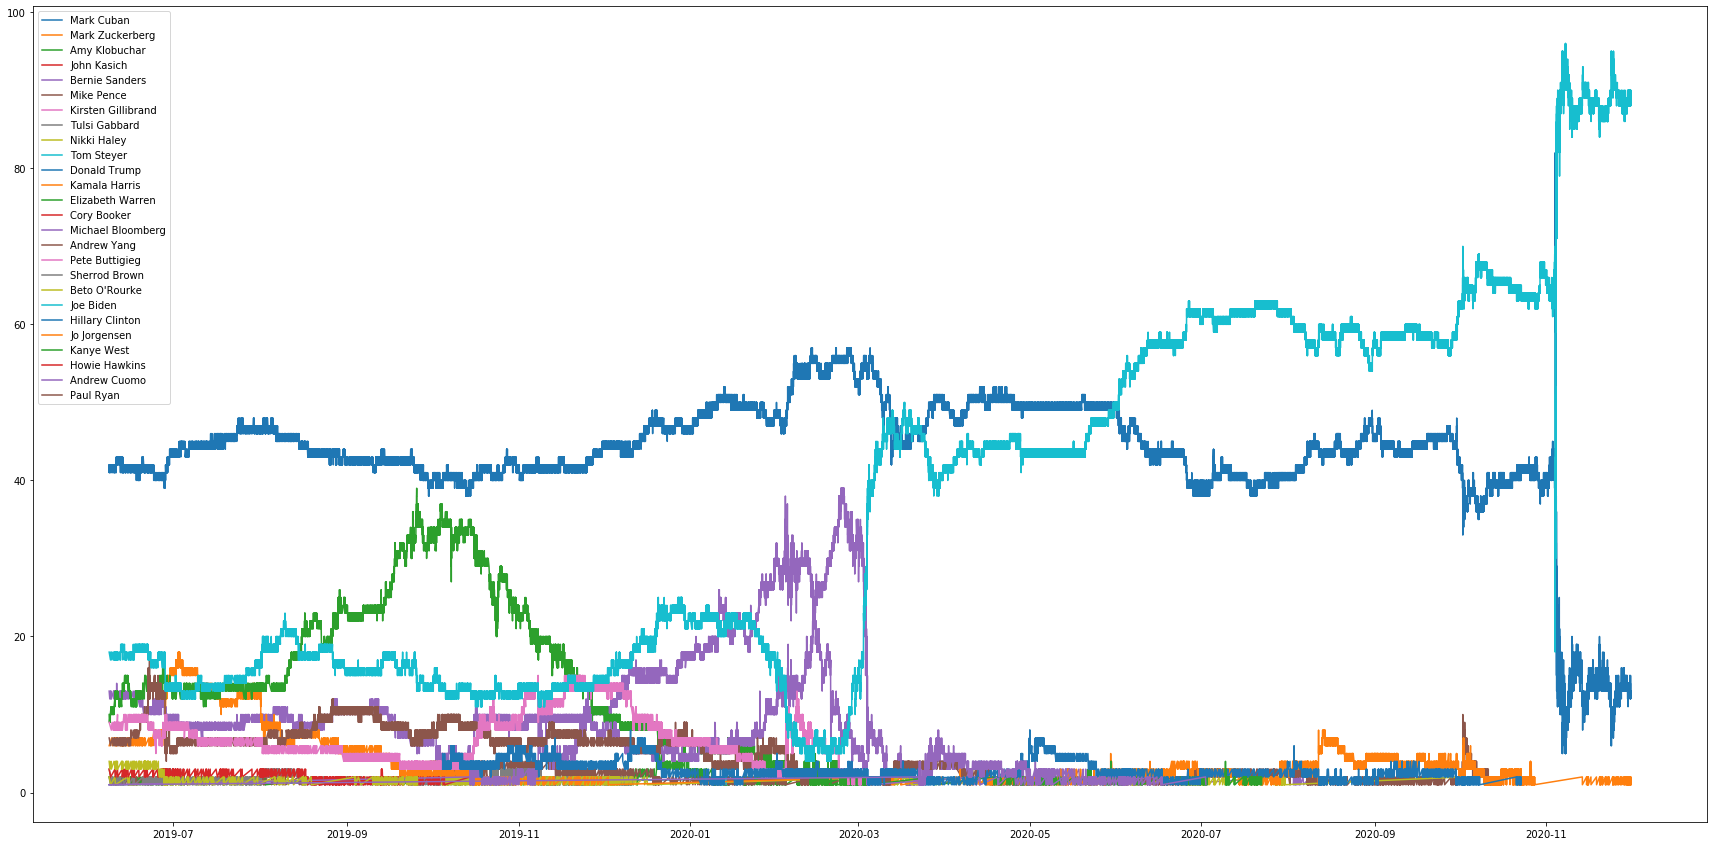

In [308]:
fig = plt.figure(figsize=(30,15))
for idx,p_df in enumerate(prez_dfs):
#     p_df = p_df[(p_df.index >= '2020-11-03') & (p_df.index <= '2020-11-05')]
    plt.plot(p_df.index,p_df['lastTradePrice'],label=c_prez.iloc[idx]['name'])
plt.legend()

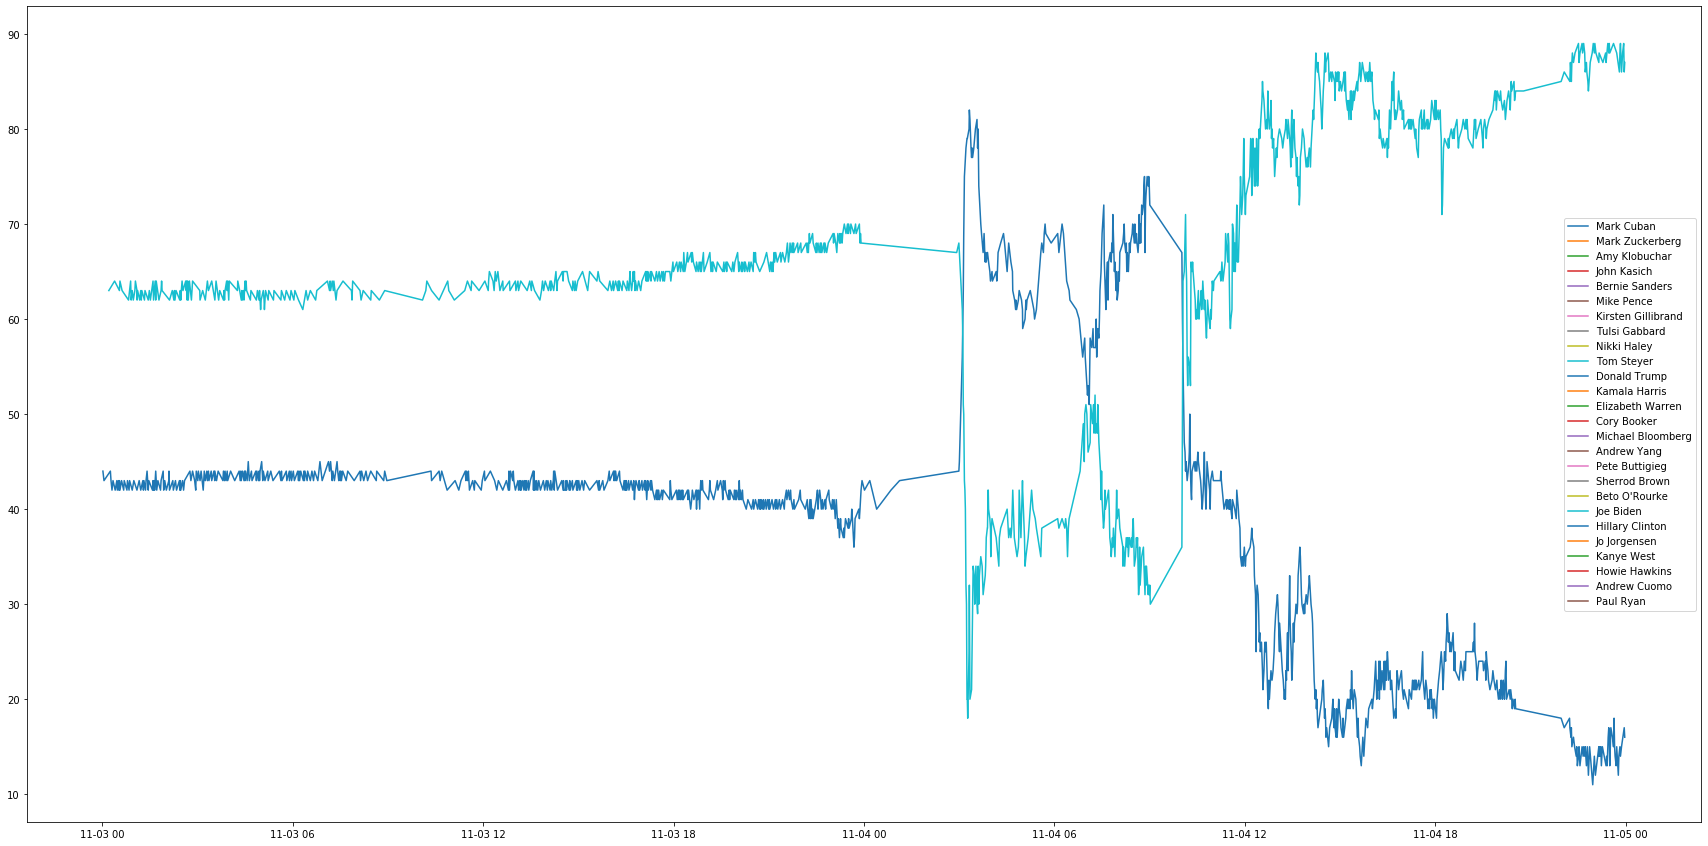

In [303]:
# election night

fig = plt.figure(figsize=(30,15))
for idx,p_df in enumerate(prez_dfs):
    p_df = p_df[(p_df.index >= '2020-11-03') & (p_df.index <= '2020-11-05')]
    plt.plot(p_df.index,p_df['lastTradePrice'],label=c_prez.iloc[idx]['name'])
plt.legend()

In [278]:
c_df[c_df['longName'].str.contains('presidential election') & c_df['longName'].str.contains('2020')][['longName','parentId']]

,longName,parentId
1747,Will a Republican candidate win OH in the 2020...,5600.0
2878,Will a Republican candidate win NH in the 2020...,5598.0
3932,Will a Democratic candidate win NH in the 2020...,5598.0
5389,Will a Republican candidate win NC in the 2020...,5599.0
5501,Will a Democratic candidate win TX in the 2020...,5798.0
5894,Will Mark Cuban win the 2020 U.S. presidential...,3698.0
6042,Will a Democratic candidate win Minnesota in t...,5597.0
6094,Will a Republican candidate win TX in the 2020...,5798.0
6365,Will a Republican candidate win NV in the 2020...,5601.0
6622,Will Mark Zuckerberg win the 2020 U.S. preside...,3698.0


In [237]:
adf_check(df['lastTradePrice'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.1276179825993236
p-value : 0.703933471106356
#Lags Used : 20
Number of Observations Used : 10996
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [15]:
df['lastTradePriceDiff'] = df['lastTradePrice'] - df['lastTradePrice'].shift(1)
adf_check(df['lastTradePriceDiff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -26.596641967371074
p-value : 0.0
#Lags Used : 19
Number of Observations Used : 10996
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


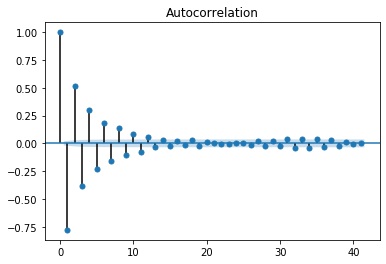

In [17]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
df_diff = plot_acf(df["lastTradePriceDiff"].dropna())

In [24]:
model = ARIMA(df["lastTradePriceDiff"].dropna(), order=(5,1,1))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARIMA Model Results                               
Dep. Variable:     D.lastTradePriceDiff   No. Observations:                11015
Model:                   ARIMA(5, 1, 1)   Log Likelihood              -10108.132
Method:                         css-mle   S.D. of innovations              0.606
Date:                  Tue, 01 Dec 2020   AIC                          20232.263
Time:                          11:24:23   BIC                          20290.719
Sample:                               1   HQIC                         20251.955
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         3.7e-07   5.93e-06      0.062      0.950   -1.13e-05     1.2e-05
ar.L1.D.lastTradePriceDiff    -1.0390      0.010   -108.728      0.

In [10]:
daily_px = df.resample('1D',how='mean')
daily_px = daily_px.ffill()
daily_px = daily_px.bfill()

daily_px.index += datetime.timedelta(days=1)

plt.plot(daily_px['lastTradePrice'])

plt.show()

daily_px['ret'] = daily_px['lastTradePrice'].diff()

_ = plt.hist(daily_px['ret'],bins=50)
plt.show()

plt.scatter(daily_px['ret'],daily_px['ret'].shift(-1))
plt.show()

daily_px['ret'].corr(daily_px['ret'].shift(-1))

TypeError: resample() got an unexpected keyword argument 'how'

In [ ]:
#######################
# time of day effects #
#######################

# average/median intraday price movement
plt.locator_params(nbins=10)

g_day = df.groupby(df.index.date)
# g_week = df.groupby(pd.Grouper(key='dateCol',freq='W-MON'))
fig = plt.figure(figsize=(20,10))
price_days = [] 
for n,g in g_day:
    if len(g) < 5:
        continue
#     print(g.columns)
#     g = g.set_index('date')
    g = g.sort_index()
#     print(g)
    g = g.resample('30T', how='mean').interpolate(method='time')
#     print(g)
    midnight = g.index[0].replace(hour=0,minute=0, second=0,microsecond=0)
#     print(pd.date_range(midnight, midnight + datetime.timedelta(hours=23,minutes=59),freq='30T'))
    g = g.reindex(pd.date_range(midnight, midnight + datetime.timedelta(hours=23,minutes=59),freq='30T'))
#     print(g)
#     print(g)
    g = g.bfill()
    g = g.ffill()
    start_price = g['lastTradePrice'].iloc[0]
    
#     xaxis = g.index.time
    xaxis = g.index - g.index[0]
#     print(xaxis)
    
    plt.plot([pd.to_datetime('2020-01-01').normalize() + dt for dt in xaxis],g['lastTradePrice'] - start_price,alpha=0.3)
#     print(len(g['lastTradePrice'].values))
    price_days.append(list(g['lastTradePrice'].values))
plt.ylim((-10,10))

In [ ]:
price_days = np.array(price_days)

In [ ]:
print('expect %d days of data' % (df.index[-1] - df.index[0]).days)

In [ ]:
print('actually %d days of data' % len(price_days))

In [ ]:
price_diffs

In [ ]:
price_diffs = pri

In [ ]:
avg_ret = (price_days[:,-1] - price_days[:,0]).mean()


In [ ]:
# price_chngs = np.diff(price_days,axis=1)
dt = datetime.datetime(2020,1,1).replace(hour=0,minute=0, second=0,microsecond=0)
xaxis = pd.date_range(dt, dt + datetime.timedelta(hours=23,minutes=59),freq='30T').time

price_chngs = (price_days[:,1:] - price_days[:,:-1])
price_chngs -= avg_ret / price_chngs.shape[1]

price_diffs = np.concatenate(([[0]]*len(price_chngs),price_chngs.cumsum(axis=1)),axis=1)
#
# price_diffs = (price_days[:,:].T - price_days[:,0]).T
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

ax2 = ax1.twinx()
ax1.plot(xaxis,price_diffs.mean(axis=0),label='mean')
ax1.plot(xaxis,np.median(price_diffs,axis=0),label='median')
ax2.plot(xaxis,np.std(price_diffs,axis=0),color='green',label='std')


plt.show()




plt.plot(xaxis[1:], price_chngs.mean(axis=0))
plt.plot(xaxis[1:], price_chngs.std(axis=0))


In [ ]:
# why is standard deviation lower on weekends?

# intraday vol probably lowest from 5:30-10 CST/NYC or so becaus all timezones aree quite late

In [ ]:
price_days.shape

In [ ]:
avg_ret = (price_days[:,-1] - price_days[:,0]).mean()


In [ ]:
# price_chngs = np.diff(price_days,axis=1)

dt = datetime.datetime(2020,1,1).replace(hour=0,minute=0, second=0,microsecond=0)
xaxis = pd.date_range(dt, dt + datetime.timedelta(days=6,hours=23,minutes=59),freq='30T')

price_chngs = (price_days[:,1:] - price_days[:,:-1])
price_chngs -= avg_ret / price_diffs.shape[1]

price_diffs = np.concatenate(([[0]]*len(price_chngs),price_chngs.cumsum(axis=1)),axis=1)
# (price_days[:,:].T - price_days[:,0]).T

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

ax2 = ax1.twinx()
ax1.plot(xaxis,price_diffs.mean(axis=0),color='blue',label='mean')
ax1.plot(xaxis,np.median(price_diffs,axis=0),color='orange',label='median')
ax2.plot(xaxis,np.std(price_diffs,axis=0),color='green',label='std')

plt.show()




plt.plot(xaxis[1:], price_chngs.mean(axis=0))
plt.plot(xaxis[1:], price_chngs.std(axis=0))


In [ ]:
from scipy.stats import ttest_ind

In [ ]:
friday_start = 144
friday_end = friday_start + 96

friday_chngs = price_chngs[:,friday_start:friday_end].cumsum(axis=1)[:,-1]
print(friday_chngs.mean(), friday_chngs.std())

In [ ]:
daily_px = df.resample('1D',how='mean')
daily_px = daily_px.ffill()
daily_px = daily_px.bfill()

daily_px.index += datetime.timedelta(days=1)

plt.plot(daily_px['lastTradePrice'])

plt.show()

daily_px['ret'] = daily_px['lastTradePrice'].diff()

_ = plt.hist(daily_px['ret'],bins=50)
plt.show()

plt.scatter(daily_px['ret'],daily_px['ret'].shift(-1))
plt.show()

daily_px['ret'].corr(daily_px['ret'].shift(-1))

In [ ]:
import statsmodels.api as sm

In [ ]:
price_diffs.cumsum(axis=1)[:,-1].mean()

In [ ]:
import datetime
day = g_day.get_group(datetime.date(2020,1,1))

In [ ]:
daily_index = pd.date_range("00:01", "23:59", freq="30min").time

# day['lastTradePrice'].reindex(pd.interpolate(method='time')

In [ ]:
df['date'].diff().nlargest(25)